In [1]:
import torch
import albumentations as A
from albumentations.pytorch import ToTensorV2
import torch.nn as nn
import torch.optim as optim
from model import UNET
from dataloader import get_loaders_heatmaps
import FILE_PATHS
import pandas as pd
import numpy as np
from training_landmarks import(
    train, 
    plot_loss_curves
)
from utils import (
    load_checkpoint,
    save_checkpoint,
    check_accuracy,
    save_predictions_as_imgs,
    train_fn
)

In [2]:
# Hyperparameters
LEARNING_RATE = 1e-4
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
BATCH_SIZE = 64
NUM_EPOCHS = 10
NUM_WORKERS = 4
IMAGE_HEIGHT = 112
IMAGE_WIDTH = 112
PIN_MEMORY = True
LOAD_MODEL = False

filename = "../EchoNet-Dynamic/models/landmark_model.pth.tar"

In [ ]:
# Check if GPUs are available
if torch.cuda.is_available():
    # Get the number of available GPUs
    num_gpus = torch.cuda.device_count()

    print(f"Number of GPUs available: {num_gpus}")

    # Iterate through available GPUs
    for gpu_id in range(num_gpus):
        print(f"GPU {gpu_id}: {torch.cuda.get_device_name(gpu_id)}")
else:
    print("No GPUs available.")

In [3]:
# Transformations
train_transforms = A.Compose(
    [
        A.Resize(height=IMAGE_HEIGHT, width=IMAGE_WIDTH),
        # A.Rotate(limit=35, p=1.0),
        # A.HorizontalFlip(p=0.5),
        # A.VerticalFlip(p=0.1),
        A.Normalize(
            mean=[0.0, 0.0, 0.0],
            std=[1.0, 1.0, 1.0],
            max_pixel_value=255.0,
        ),
        ToTensorV2(),
    ]
)

val_transforms = A.Compose(
    [
        A.Resize(height=IMAGE_HEIGHT, width=IMAGE_WIDTH),
        A.Normalize(
            mean=[0.0, 0.0, 0.0],
            std=[1.0, 1.0, 1.0],
            max_pixel_value=255.0,
        ),
        ToTensorV2(),
    ]
)

In [4]:
# MODEL
model = UNET(in_channels=3, out_channels=7).to(DEVICE)
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

In [5]:
# BATCHES
train_loader, val_loader = get_loaders_heatmaps(
    FILE_PATHS.IMAGES,
    f"{FILE_PATHS.HEATMAPS}/gaussian",
    FILE_PATHS.MASKS,
    BATCH_SIZE,
    train_transforms,
    val_transforms,
    NUM_WORKERS,
    test_size=0.2,
    seed=42,
)

TRAIN PATHS LENGTHS: images, masks, heatmaps
16, 16, 16
VALIDATION PATHS LENGTHS: images, masks, heatmaps
4, 4, 4


In [6]:
if LOAD_MODEL:
    load_checkpoint(torch.load("landmark_model.pth.tar"), model)

landmark_results = train(model=model, 
                        train_dataloader=train_loader,
                        test_dataloader=val_loader,
                        optimizer=optimizer,
                        loss_fn=loss_fn, 
                        epochs=NUM_EPOCHS,
                        device=DEVICE)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.0674 | train_acc: 0.0974 | test_loss: 0.0677 | test_acc: 0.1752


 10%|█         | 1/10 [01:04<09:41, 64.64s/it]

Epoch: 2 | train_loss: 0.0666 | train_acc: 0.1288 | test_loss: 0.0677 | test_acc: 0.2009


 20%|██        | 2/10 [01:37<06:07, 45.93s/it]

Epoch: 3 | train_loss: 0.0660 | train_acc: 0.1696 | test_loss: 0.0677 | test_acc: 0.0828


 30%|███       | 3/10 [02:08<04:33, 39.14s/it]

Epoch: 4 | train_loss: 0.0654 | train_acc: 0.1961 | test_loss: 0.0677 | test_acc: 0.0820


 40%|████      | 4/10 [02:29<03:11, 31.92s/it]

Epoch: 5 | train_loss: 0.0649 | train_acc: 0.2009 | test_loss: 0.0677 | test_acc: 0.1686


 50%|█████     | 5/10 [02:48<02:15, 27.13s/it]

Epoch: 6 | train_loss: 0.0644 | train_acc: 0.1527 | test_loss: 0.0677 | test_acc: 0.2720


 60%|██████    | 6/10 [03:07<01:38, 24.62s/it]

Epoch: 7 | train_loss: 0.0639 | train_acc: 0.1932 | test_loss: 0.0677 | test_acc: 0.2670


 70%|███████   | 7/10 [03:26<01:08, 22.74s/it]

Epoch: 8 | train_loss: 0.0633 | train_acc: 0.2700 | test_loss: 0.0677 | test_acc: 0.3205


 80%|████████  | 8/10 [03:47<00:44, 22.01s/it]

Epoch: 9 | train_loss: 0.0628 | train_acc: 0.2597 | test_loss: 0.0677 | test_acc: 0.3185


 90%|█████████ | 9/10 [04:10<00:22, 22.33s/it]

Epoch: 10 | train_loss: 0.0621 | train_acc: 0.2607 | test_loss: 0.0677 | test_acc: 0.2861


100%|██████████| 10/10 [04:29<00:00, 26.93s/it]


In [13]:
# save model
checkpoint = {
    "state_dict": model.state_dict(),
    "optimizer": optimizer.state_dict(),
}

save_checkpoint(checkpoint, filename)

=> Saving checkpoint


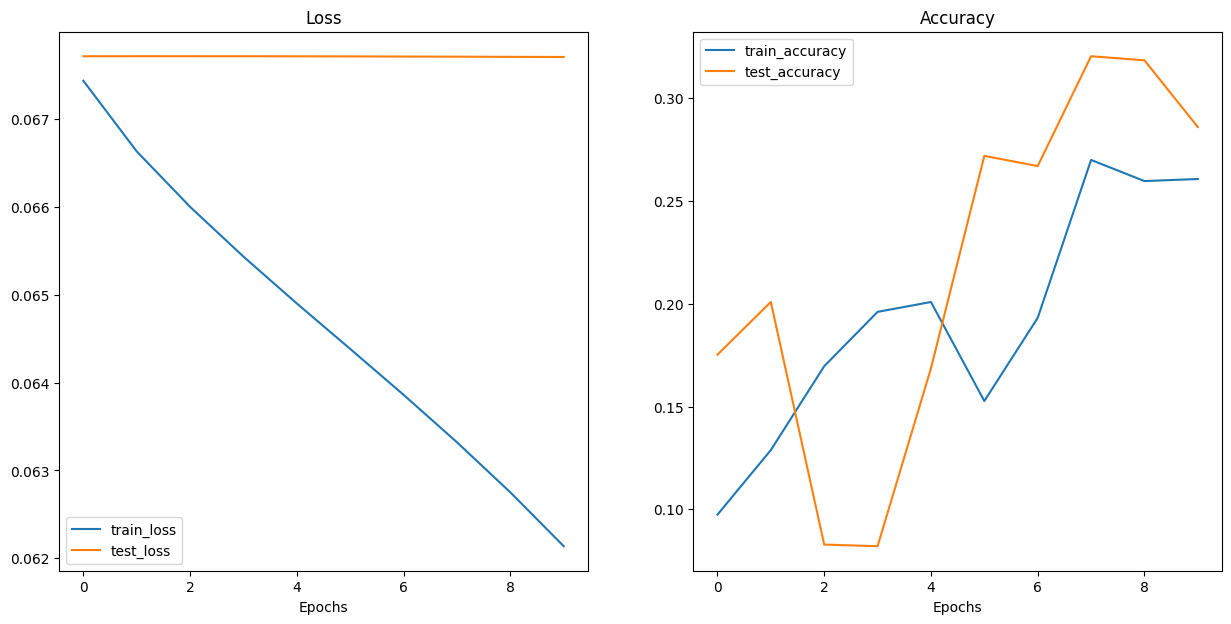

In [12]:
plot_loss_curves(landmark_results)

In [10]:
landmark_model = pd.DataFrame(landmark_results)
landmark_model.to_csv("mask_model.csv")
